# Emotion Dataset Multiclass NLP Classification

## Import Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
!pip install nlp
import nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 30.2 MB/s 
     |████████████████████████████████| 212 kB 54.5 MB/s 


In [2]:
tf.__version__

'2.8.2'

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get Data

In [4]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
# Split dataset into train, validation and test
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

## Preprocess Data

In [6]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [7]:
train

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [8]:
import numpy as np
def get_split_data(data):

  """
  Splits the data into text and labels
  """
  text = [x["text"] for x in data]
  labels = np.array([x["label"] for x in data])

  return text, labels

In [9]:
# Train
train_sentences, train_labels = get_split_data(train)
print(f"Train:\n{train_sentences[0], train_labels[0]}")
# Validation
val_sentences, val_labels = get_split_data(val)
print(f"Val:\n{val_sentences[0], val_labels[0]}")
# Test
test_sentences, test_labels = get_split_data(test)
print(f"Test:\n{test_sentences[0], test_labels[0]}")

Train:
('i didnt feel humiliated', 'sadness')
Val:
('im feeling quite sad and sorry for myself but ill snap out of it soon', 'sadness')
Test:
('im feeling rather rotten so im not very ambitious right now', 'sadness')


In [10]:
# Train Labels
import pandas as pd
pd.DataFrame(train_labels).value_counts() # 6 Lables -> One Hot Encode

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
dtype: int64

In [11]:
# Num Classes
num_classes_ = len(pd.DataFrame(train_labels).value_counts())
num_classes_

6

In [12]:
train_labels[:5]
train_labels.reshape(-1, 1)

array([['sadness'],
       ['sadness'],
       ['anger'],
       ...,
       ['joy'],
       ['anger'],
       ['sadness']], dtype='<U8')

In [13]:
# One Hot Encode -> Base Line
import sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)
print(f"Train Labels Shape: {train_labels_encoded.shape}\n Train Labels: {train_labels_encoded}")


Train Labels Shape: (16000,)
 Train Labels: [4 4 0 ... 2 0 4]


In [14]:
# One Hot Matrix -> Deep Learning Labels
import sklearn
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot.transform(val_labels.reshape(-1, 1))
test_labels_one_hot = one_hot.transform(test_labels.reshape(-1, 1))
print(f"Train Labels Shape: {train_labels_one_hot.shape}\n Train Labels; {train_labels_one_hot}")

Train Labels Shape: (16000, 6)
 Train Labels; [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


## About the Sentences

In [15]:
train_sentences[:10]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too']

In [16]:
# Length of sentences
sent_length = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_length)
avg_sent_len

19.1663125

In [17]:
# How long of a sentence length covers 95% of the training sentences
OUTPUT_SEQ_LENGHT = int(np.percentile(sent_length, 95))
OUTPUT_SEQ_LENGHT

41

## Helper Functions

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Model 0: Baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
            y = val_labels_encoded)

0.641

In [21]:
model_0.predict(val_sentences).shape 

(2000,)

In [22]:
model_0_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_0.predict(val_sentences))
model_0_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 64.1,
 'f1': 0.5476309366603793,
 'precision': 0.7148671181119123,
 'recall': 0.641}

## Text Vectorization Layer



In [23]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

MAX_LENGTH = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
print(f"Maxium Length: {MAX_LENGTH}")

# Setup the vectorization variables
MAX_VOCAB_LENGTH = 10_000
OUTPUT_MODE = "int"

text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_LENGTH, # how many words in the vocab
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode=OUTPUT_MODE,
                                    output_sequence_length=MAX_LENGTH, # how long should the sequences be
                                    pad_to_max_tokens=True)

Maxium Length: 19


In [24]:
text_vectorizer.adapt(train_sentences)

## Embeddings Layer

In [25]:
from tensorflow.keras import layers

OUTPUT_DIM = 128

embedding = layers.Embedding(input_dim = MAX_VOCAB_LENGTH,
                            output_dim = OUTPUT_DIM,
                            input_length = MAX_LENGTH)

## tf.Dataset 

In [26]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [27]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>

## Model 1: Feed Forward Dense

In [28]:
# Build a model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(6, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [29]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 19)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 19, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1,280,774
Trainable params: 1,280,774
N

In [30]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [31]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 *len(train_dataset)),
                              epochs = 10,
                              validation_data = val_dataset,
                              validation_steps = int(0.1 *len(val_dataset)))

Epoch 1/10
50/50 [==============================] - 2s 22ms/step - loss: 1.7305 - accuracy: 0.3694 - val_loss: 1.6662 - val_accuracy: 0.3333
Epoch 2/10
50/50 [==============================] - 1s 14ms/step - loss: 1.6048 - accuracy: 0.3844 - val_loss: 1.5844 - val_accuracy: 0.3802
Epoch 3/10
50/50 [==============================] - 1s 16ms/step - loss: 1.5496 - accuracy: 0.4119 - val_loss: 1.5665 - val_accuracy: 0.3698
Epoch 4/10
50/50 [==============================] - 1s 20ms/step - loss: 1.5626 - accuracy: 0.4044 - val_loss: 1.5461 - val_accuracy: 0.3854
Epoch 5/10
50/50 [==============================] - 1s 22ms/step - loss: 1.5224 - accuracy: 0.4394 - val_loss: 1.5186 - val_accuracy: 0.3854
Epoch 6/10
50/50 [==============================] - 1s 22ms/step - loss: 1.4763 - accuracy: 0.4425 - val_loss: 1.4913 - val_accuracy: 0.4375
Epoch 7/10
50/50 [==============================] - 1s 22ms/step - loss: 1.4495 - accuracy: 0.4737 - val_loss: 1.4662 - val_accuracy: 0.4688
Epoch 8/10
50

In [32]:
# Evaluate the dataset
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_1.predict(val_dataset), axis = 1))
model_1_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 55.00000000000001,
 'f1': 0.42335876086633484,
 'precision': 0.3444759684198804,
 'recall': 0.55}

## Model 2: THub Encoder -> Universal Sentence Encoder

In [33]:
# Download pretrained USE model
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                    trainable = False, name = "USE")

In [34]:
# Build the model
inputs = layers.Input(shape = [], dtype = tf.string)
embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = "relu")(embeddings)
outputs = layers.Dense(6, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "USE_Model")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_model_2 = model_2.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs = 10,
                             validation_data = val_dataset,
                             validation_steps = int(0.1*len(val_dataset)))

Epoch 1/10
50/50 [==============================] - 3s 20ms/step - loss: 1.5877 - accuracy: 0.4150 - val_loss: 1.4615 - val_accuracy: 0.4479
Epoch 2/10
50/50 [==============================] - 1s 12ms/step - loss: 1.3501 - accuracy: 0.5144 - val_loss: 1.2934 - val_accuracy: 0.5260
Epoch 3/10
50/50 [==============================] - 1s 11ms/step - loss: 1.2050 - accuracy: 0.5750 - val_loss: 1.1703 - val_accuracy: 0.5885
Epoch 4/10
50/50 [==============================] - 1s 12ms/step - loss: 1.1798 - accuracy: 0.5825 - val_loss: 1.1206 - val_accuracy: 0.5833
Epoch 5/10
50/50 [==============================] - 1s 11ms/step - loss: 1.0726 - accuracy: 0.6231 - val_loss: 1.0816 - val_accuracy: 0.5938
Epoch 6/10
50/50 [==============================] - 1s 11ms/step - loss: 1.0255 - accuracy: 0.6256 - val_loss: 1.0697 - val_accuracy: 0.5990
Epoch 7/10
50/50 [==============================] - 1s 11ms/step - loss: 1.0294 - accuracy: 0.6119 - val_loss: 1.0389 - val_accuracy: 0.6250
Epoch 8/10
50

In [35]:
# Evaluate the model
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_2.predict(val_dataset), axis = 1))
model_2_results

{'accuracy': 63.800000000000004,
 'f1': 0.6205207044520603,
 'precision': 0.6480890972505801,
 'recall': 0.638}

## Model 3: Conv1D

In [36]:
# create 1d conv model
inputs = layers.Input(shape = (1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size = 5, padding = "same",
                 activation = "relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(6, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "conv1d_model")

In [37]:
# Compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_model_3 = model_3.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs = 10,
                             validation_data = val_dataset,
                             validation_steps = int(0.1*len(val_dataset)))

Epoch 1/10
50/50 [==============================] - 2s 23ms/step - loss: 1.4257 - accuracy: 0.4769 - val_loss: 1.2854 - val_accuracy: 0.5208
Epoch 2/10
50/50 [==============================] - 1s 19ms/step - loss: 1.0774 - accuracy: 0.6250 - val_loss: 1.0553 - val_accuracy: 0.6719
Epoch 3/10
50/50 [==============================] - 1s 19ms/step - loss: 0.8663 - accuracy: 0.7331 - val_loss: 0.8365 - val_accuracy: 0.7344
Epoch 4/10
50/50 [==============================] - 1s 19ms/step - loss: 0.7258 - accuracy: 0.7738 - val_loss: 0.7267 - val_accuracy: 0.7969
Epoch 5/10
50/50 [==============================] - 1s 18ms/step - loss: 0.6129 - accuracy: 0.8125 - val_loss: 0.6693 - val_accuracy: 0.7917
Epoch 6/10
50/50 [==============================] - 1s 19ms/step - loss: 0.5551 - accuracy: 0.8225 - val_loss: 0.6040 - val_accuracy: 0.8125
Epoch 7/10
50/50 [==============================] - 1s 18ms/step - loss: 0.4978 - accuracy: 0.8388 - val_loss: 0.6145 - val_accuracy: 0.8073
Epoch 8/10
50

In [38]:
# Evaluate the model
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_3.predict(val_dataset), axis = 1))
model_3_results

{'accuracy': 81.69999999999999,
 'f1': 0.8080714415514698,
 'precision': 0.8212872747461504,
 'recall': 0.817}

## Model 4: Bi-Directional RNN

In [39]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(num_classes_, activation = "softmax")(x)
model_4 = tf.keras.Model(inputs, outputs, name = "model_4_bidirectional")

# Compile model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model

history_model_4 = model_4.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 10,
                              validation_data = val_dataset,
                              validation_steps = int(0.1 * len(val_dataset))) 

Epoch 1/10
50/50 [==============================] - 14s 120ms/step - loss: 1.2193 - accuracy: 0.5500 - val_loss: 0.7393 - val_accuracy: 0.7344
Epoch 2/10
50/50 [==============================] - 3s 61ms/step - loss: 0.5404 - accuracy: 0.8125 - val_loss: 0.6738 - val_accuracy: 0.7969
Epoch 3/10
50/50 [==============================] - 3s 59ms/step - loss: 0.4232 - accuracy: 0.8575 - val_loss: 0.5718 - val_accuracy: 0.8177
Epoch 4/10
50/50 [==============================] - 3s 59ms/step - loss: 0.3714 - accuracy: 0.8681 - val_loss: 0.5204 - val_accuracy: 0.8281
Epoch 5/10
50/50 [==============================] - 3s 60ms/step - loss: 0.3449 - accuracy: 0.8831 - val_loss: 0.5641 - val_accuracy: 0.8490
Epoch 6/10
50/50 [==============================] - 3s 58ms/step - loss: 0.3427 - accuracy: 0.8813 - val_loss: 0.5298 - val_accuracy: 0.8073
Epoch 7/10
50/50 [==============================] - 3s 57ms/step - loss: 0.3017 - accuracy: 0.8981 - val_loss: 0.5832 - val_accuracy: 0.8073
Epoch 8/10


In [40]:
# Evaluate the model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_4.predict(val_dataset), axis = 1))
model_4_results

{'accuracy': 83.1,
 'f1': 0.8308998443684024,
 'precision': 0.8315797620231371,
 'recall': 0.831}

## Model 5: Bi-Directional LSTM

In [41]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(num_classes_, activation = "softmax")(x)
model_5 = tf.keras.Model(inputs, outputs, name = "model_5_bidirectional")

# Compile model
model_5.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model

history_model_5 = model_5.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 10,
                              validation_data = val_dataset,
                              validation_steps = int(0.1 * len(val_dataset)))

# Evaluate the model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_5.predict(val_dataset), axis = 1))
model_5_results

Epoch 1/10
50/50 [==============================] - 11s 95ms/step - loss: 1.1087 - accuracy: 0.5869 - val_loss: 0.7091 - val_accuracy: 0.7448
Epoch 2/10
50/50 [==============================] - 3s 62ms/step - loss: 0.4460 - accuracy: 0.8450 - val_loss: 0.6118 - val_accuracy: 0.8021
Epoch 3/10
50/50 [==============================] - 3s 62ms/step - loss: 0.3523 - accuracy: 0.8794 - val_loss: 0.6159 - val_accuracy: 0.7969
Epoch 4/10
50/50 [==============================] - 3s 69ms/step - loss: 0.3135 - accuracy: 0.8944 - val_loss: 0.5852 - val_accuracy: 0.8229
Epoch 5/10
50/50 [==============================] - 3s 64ms/step - loss: 0.2830 - accuracy: 0.9106 - val_loss: 0.6048 - val_accuracy: 0.8281
Epoch 6/10
50/50 [==============================] - 3s 61ms/step - loss: 0.2706 - accuracy: 0.9156 - val_loss: 0.5696 - val_accuracy: 0.8229
Epoch 7/10
50/50 [==============================] - 3s 61ms/step - loss: 0.2437 - accuracy: 0.9181 - val_loss: 0.6237 - val_accuracy: 0.7760
Epoch 8/10
5

{'accuracy': 83.05,
 'f1': 0.8316647430473804,
 'precision': 0.8357920184268038,
 'recall': 0.8305}

## Model 6: Bi-Directional GRU

In [42]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(num_classes_, activation = "softmax")(x)
model_6 = tf.keras.Model(inputs, outputs, name = "model_6_bidirectional")

# Compile model
model_6.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model

history_model_6 = model_6.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 10,
                              validation_data = val_dataset,
                              validation_steps = int(0.1 * len(val_dataset)))

# Evaluate the model
model_6_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_6.predict(val_dataset), axis = 1))
model_6_results

Epoch 1/10
50/50 [==============================] - 11s 84ms/step - loss: 1.2050 - accuracy: 0.5381 - val_loss: 0.7992 - val_accuracy: 0.7448
Epoch 2/10
50/50 [==============================] - 3s 56ms/step - loss: 0.3869 - accuracy: 0.8781 - val_loss: 0.6393 - val_accuracy: 0.8125
Epoch 3/10
50/50 [==============================] - 3s 53ms/step - loss: 0.2830 - accuracy: 0.9100 - val_loss: 0.6567 - val_accuracy: 0.8073
Epoch 4/10
50/50 [==============================] - 3s 54ms/step - loss: 0.2709 - accuracy: 0.9062 - val_loss: 0.5993 - val_accuracy: 0.8281
Epoch 5/10
50/50 [==============================] - 3s 55ms/step - loss: 0.2201 - accuracy: 0.9281 - val_loss: 0.6249 - val_accuracy: 0.8594
Epoch 6/10
50/50 [==============================] - 3s 51ms/step - loss: 0.2325 - accuracy: 0.9256 - val_loss: 0.6245 - val_accuracy: 0.8281
Epoch 7/10
50/50 [==============================] - 3s 56ms/step - loss: 0.1961 - accuracy: 0.9381 - val_loss: 0.6152 - val_accuracy: 0.8073
Epoch 8/10
5

{'accuracy': 83.35000000000001,
 'f1': 0.8350978200716219,
 'precision': 0.8406103736986235,
 'recall': 0.8335}

## Model 7: Character Level Embeddings + Universal Sentence Encoder

In [43]:
# Make a function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))


# Text Splitting non-character-level sequences into characters
train_chars = [split_chars(sentences) for sentences in train_sentences]
val_chars = [split_chars(sentences) for sentences in val_sentences]
test_chars = [split_chars(sentences) for sentences in test_sentences]

print(train_chars[:5])

['i   d i d n t   f e e l   h u m i l i a t e d', 'i   c a n   g o   f r o m   f e e l i n g   s o   h o p e l e s s   t o   s o   d a m n e d   h o p e f u l   j u s t   f r o m   b e i n g   a r o u n d   s o m e o n e   w h o   c a r e s   a n d   i s   a w a k e', 'i m   g r a b b i n g   a   m i n u t e   t o   p o s t   i   f e e l   g r e e d y   w r o n g', 'i   a m   e v e r   f e e l i n g   n o s t a l g i c   a b o u t   t h e   f i r e p l a c e   i   w i l l   k n o w   t h a t   i t   i s   s t i l l   o n   t h e   p r o p e r t y', 'i   a m   f e e l i n g   g r o u c h y']


In [44]:
# What is the average character lenght
char_len = [len(sentence) for sentence in train_sentences]
MEAN_CHAR_LEN = np.mean(char_len)
MEAN_CHAR_LEN

96.8458125

In [45]:
# What character level cover 95% of sequences
OUTPUT_SEQ_LENGHT_CHAR = int(np.percentile(char_len, 95))
OUTPUT_SEQ_LENGHT_CHAR

207

In [46]:
# Create-char level token vectorizer instance
import string
NUM_CHAR_TOKENS = len(string.ascii_lowercase +
                      string.digits +
                      string.punctuation) + 2
char_vectorizer = TextVectorization(
        max_tokens = NUM_CHAR_TOKENS,
        output_sequence_length = OUTPUT_SEQ_LENGHT_CHAR
        ,name = "char_vectorizer")

In [47]:
char_vectorizer.adapt(train_chars)

In [48]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
print(char_vocab[:-5])
# Create the embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                             output_dim = 25, mask_zero = True,
                            name = "char_embed")

28
['', '[UNK]', 'e', 't', 'i']
['', '[UNK]', 'e', 't', 'i', 'a', 'o', 'n', 's', 'l', 'r', 'h', 'd', 'f', 'm', 'u', 'g', 'y', 'c', 'w', 'p', 'b', 'v']


In [49]:
# 1. Setup Token inputs/models

token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Setup char input/model

char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
print(char_embeddings.shape)
char_bi_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(char_embeddings)
char_bi_lstm_2 = layers.Bidirectional(layers.GRU(64))(char_bi_lstm)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm_2)

# 3. Concatenate token and char inputs

token_char_concat = layers.Concatenate(name = "token_char_hybrid")([
    token_model.output, char_model.output
])

# 4. Build a series of output layers and dropout layer

combined_output = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_output)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(6, activation = "softmax")(final_dropout)

model_7 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                        outputs = output_layer,
                        name = "model_7_token_and_char_embeddings")

(None, 207, 25)


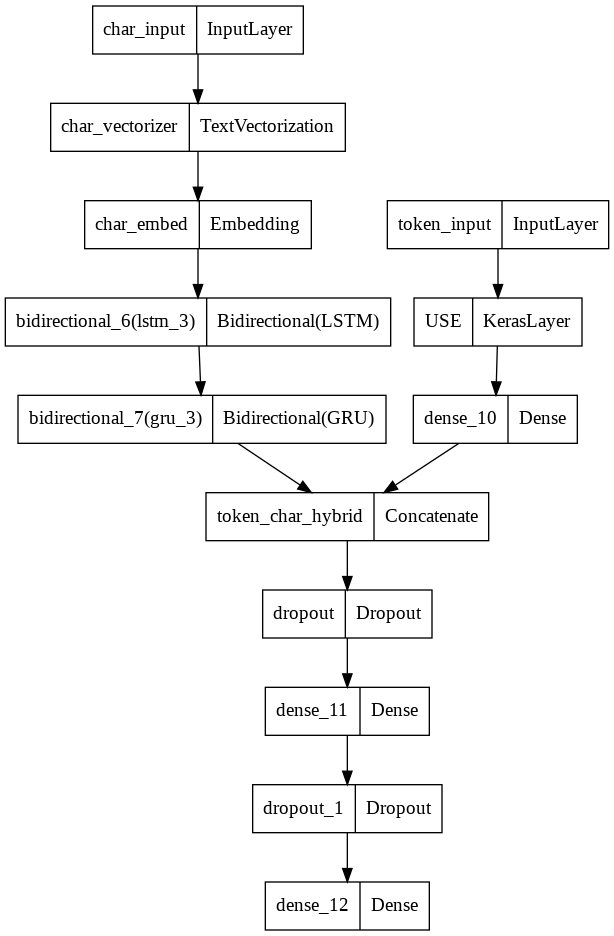

In [50]:
from keras.utils.vis_utils import plot_model
plot_model(model_7)

In [51]:
# Compile the model
model_7.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


# Combine tokens and chars
train_token_char_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot
)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,
train_token_char_labels))
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Combine tokens and chars - validation
val_token_char_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(
    val_labels_one_hot
)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,
val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the model
history_model_7 = model_7.fit(train_token_char_dataset,
                            steps_per_epoch = int(0.1*len(train_token_char_dataset)),
                            epochs = 20,
                            validation_data = val_token_char_dataset,
                            validation_steps = int(0.1*len(val_token_char_dataset)),
                            verbose = 0)

In [52]:
# Evaluate the model
model_7_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_7.predict(val_token_char_dataset), axis = 1))
model_7_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 62.74999999999999,
 'f1': 0.5908996788173767,
 'precision': 0.6051177797793148,
 'recall': 0.6275}

## Model Results

In [81]:
all_model_results = pd.DataFrame({
    "Baseline": model_0_results,
    "Model_1_Dense": model_1_results,
    "Model_2_USE": model_2_results,
    "Model_3_Conv1D": model_3_results,
    "Model_4_bidirectional RNN": model_4_results,
    "Model_5_bidirectional LSTM": model_5_results,
    "Model_6_bidirectional GRU": model_6_results,
    "Model_7 Character Level Encoding + USE": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
Baseline,0.6410,0.714867,0.6410,0.547631
Model_1_Dense,0.5500,0.344476,0.5500,0.423359
Model_2_USE,0.6380,0.648089,0.6380,0.620521
Model_3_Conv1D,0.8170,0.821287,0.8170,0.808071
Model_4_bidirectional RNN,0.8310,0.831580,0.8310,0.830900
Model_5_bidirectional LSTM,0.8305,0.835792,0.8305,0.831665
Model_6_bidirectional GRU,0.8335,0.840610,0.8335,0.835098
Model_7 Character Level Encoding + USE,0.6275,0.605118,0.6275,0.590900


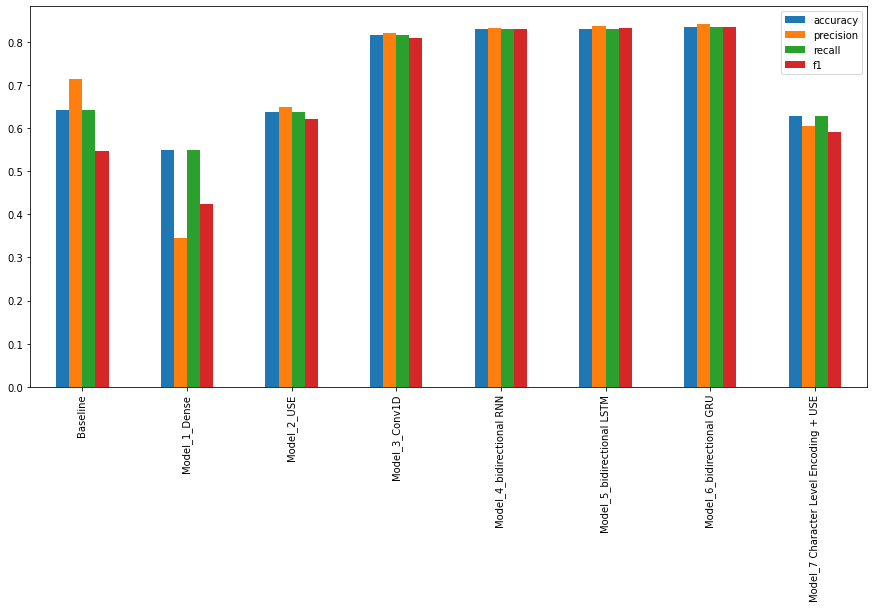

In [82]:
all_model_results.plot(kind = "bar", figsize = (15, 7)).legend(bbox_to_anchor = (1.0, 1.0));